<a href="https://colab.research.google.com/github/zeineb-ouerghi/Duolingo/blob/master/LBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries 

In [124]:
#import libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
sns.set()


In [125]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
print(fn)

KeyboardInterrupt: ignored

I made a copy of the data where the conversion of the costs to euros to make the calculations more accurate.

#Data Processing

In [126]:
#Importing the data file 
data = pd.read_csv('/content/CS146 Converted LBA Data - Converted values to Euros.csv')

#Look at the display of the data
data.head()

,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Type,Converted Rental Price,Average rental price near the grocery store,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,Germany,EUR,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),826.0,826,2.0,2.22,1.0,2.99,1.0,1.49,1.0,3.90,1.0,1.59,1.0,0.89,1.0,2.39,0.50,2.19,0.50,2.99,1.5,1.89,1.0,1.79,2.5,1.29,1.0,0.39,1.0,0.89,1.0,1.39,0.50,1.49,1.0,1.99,0.50,1.49,1.0,0.72,1.0,0.80,1.0,0.99,0.25,1.79,0.100,0.85,0.25,2.29,6.0,1.49,6.0,1.99,10.0,1.99,0.6,4.49,1.0,6.79,0.40,3.49
1,Germany,EUR,"Lidl, Leipziger Str. 42, 10117 Berlin",Budget (cheap),1090.0,1090,1.0,1.99,2.0,3.29,0.7,2.69,1.0,0.89,1.0,1.39,1.0,1.59,0.5,2.39,0.10,0.85,0.25,1.79,2.5,1.39,2.5,1.29,1.0,1.39,1.0,0.39,1.0,0.89,1.0,0.89,0.25,1.69,1.0,1.99,1.00,1.49,1.0,1.15,1.0,1.09,1.0,0.80,0.25,1.49,0.225,1.29,0.25,1.95,18.0,2.29,10.0,2.99,10.0,1.99,0.4,2.79,0.4,3.49,0.35,7.00
2,Germany,EUR,"Lidl, Hermannstraße 55",Budget (cheap),812.0,812,1.0,1.99,1.0,2.69,1.0,2.19,1.0,1.09,1.0,1.39,1.0,3.90,1.0,1.99,1.00,2.69,1.00,2.49,1.0,1.39,1.0,1.29,1.0,1.79,1.0,0.49,1.0,0.79,NaN,NaN,1.00,1.99,1.0,1.00,2.59,NaN,1.0,0.80,1.0,1.09,1.0,1.29,0.25,1.49,0.250,1.99,NaN,NaN,10.0,1.59,10.0,1.99,10.0,2.79,1.0,7.48,1.0,6.79,NaN,NaN
3,Germany,EUR,"REWE, Wrangelstraße 53",Budget (cheap),938.0,938,1.0,2.99,1.0,2.29,1.0,3.49,1.0,1.69,1.0,0.99,1.0,1.99,1.0,2.29,0.25,0.89,0.65,2.39,3.0,1.19,1.5,1.99,0.5,0.99,1.0,0.39,1.0,0.75,1.0,1.99,0.50,3.99,0.5,1.99,NaN,NaN,1.0,0.72,1.0,0.80,1.0,0.99,0.12,0.99,0.250,2.19,0.40,3.59,6.0,1.79,6.0,1.39,12.0,1.59,1.0,7.15,1.0,8.23,NaN,NaN
4,Germany,EUR,Aldi Hermanstrabe 72,Budget (cheap),892.0,892,1.0,3.58,1.0,1.75,1.0,3.15,1.0,1.09,NaN,NaN,NaN,NaN,1.0,1.98,1.00,2.39,NaN,NaN,1.0,0.52,1.0,0.60,NaN,NaN,1.0,0.39,NaN,NaN,NaN,NaN,1.00,1.99,1.0,0.99,NaN,NaN,1.0,0.72,1.0,0.99,NaN,NaN,0.10,1.49,NaN,NaN,NaN,NaN,6.0,2.99,6.0,2.50,NaN,NaN,1.0,8.16,NaN,NaN,NaN,NaN


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 66 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Country where you (and the grocery store) are                      50 non-null     object 
 1   Currency (e.g. EUR, GBP, USD)                                      50 non-null     object 
 2   Grocery store name and street address (or URL if shopping online)  50 non-null     object 
 3   Type                                                               50 non-null     object 
 4   Converted Rental Price                                             50 non-null     float64
 5   Average rental price near the grocery store                        50 non-null     object 
 6   Product 1 quantity (kg)                                            50 non-null     float64
 7   Product 1 price             

In [128]:
newlist = [['Store','Brand', 'Country','Rental','Product', 'Product ID','Quantity' , 'Price']]
product_list = ['Apples', 'Bananas', 'Tomatoes','Potatoes', 'Flour', 'Rice', 'Milk', 'full cream','Butter','Eggs' ,'Chicken breasts']
product_id = [1,2,3,4,5,6,7,8,9,10]

In [129]:
## we create a new dataframe to have a clear data to observe and analyze 
number_of_product= int((data.shape[1]-4)/2)

for i in range(data.shape[0]*number_of_product):
    productType = product_list[i//3%10]
    productID = product_id[i//3%10]
    newlist.append([data.iloc[i//number_of_product]['Grocery store name and street address (or URL if shopping online)'],
                  data.iloc[i//number_of_product]['Type'],data.iloc[i//number_of_product]['Country where you (and the grocery store) are'],data.iloc[i//number_of_product]['Converted Rental Price'],
                  productType, productID,
                  data.iloc[i//number_of_product][i%number_of_product*2+4],
                  data.iloc[i//number_of_product][i%number_of_product*2+1+4]],
                  )
# we create the data frame 
productdata = pd.DataFrame(newlist[1:],columns=newlist[0])
#we look at the data 
productdata.head()

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,826.0,826
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,2.0,2.22
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,1.0,2.99
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,1.49
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,3.9


In [159]:
#checking if there are any missing values
productdata.isnull().sum()

Store            0
Brand            0
Country          0
Rental           0
Product          0
Product ID       0
Quantity         0
Price            0
ratio            0
location_code    0
brand_code       0
dtype: int64

In [158]:
# drop the missing values 
productdata.dropna(inplace=True)
productdata.head()

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price,ratio,location_code,brand_code
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,826.0,826.00,1.00,1,1
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,2.0,2.22,1.11,1,1
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,1.0,2.99,2.99,1,1
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,1.49,1.49,1,1
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,3.90,3.90,1,1


In [132]:
productdata.replace(to_replace='2,150',value='2.150',inplace=True)
productdata.replace(to_replace='1,050',value='1.050',inplace=True)

In [133]:
productdata = productdata.astype({"Price": float, "Quantity":float})
productdata

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,826.00,826.00
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,2.00,2.22
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,1.00,2.99
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,1.49
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,3.90
...,...,...,...,...,...,...,...,...
1545,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,3.99
1546,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,6.19
1547,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,1.13,8.59
1548,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Milk,7,0.45,6.49


In [134]:
productdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 1549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Store       1376 non-null   object 
 1   Brand       1376 non-null   object 
 2   Country     1376 non-null   object 
 3   Rental      1376 non-null   float64
 4   Product     1376 non-null   object 
 5   Product ID  1376 non-null   int64  
 6   Quantity    1376 non-null   float64
 7   Price       1376 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 96.8+ KB


In [135]:
data['Average rental price near the grocery store'].describe()

count       50
unique      35
top       2150
freq         7
Name: Average rental price near the grocery store, dtype: object

In [136]:
# Count of countries 
print('\n%d Countries:'%(data['Country where you (and the grocery store) are'].nunique()))
countries = list(data['Country where you (and the grocery store) are'].unique())
countries


5 Countries:


['Germany', 'Germany ', 'UK', 'South Korea', 'United States']

In [137]:
#one of the entries in the data was mispelled
productdata.replace(to_replace='Germany ',value='Germany',inplace=True)

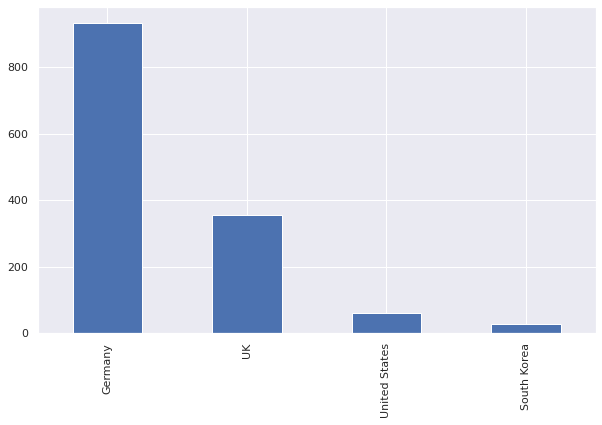

In [138]:
# Countries and count of data 
plt.figure(figsize=(10, 6))
productdata['Country'].value_counts().plot.bar()

In [139]:
print('Total of %d brands:'%(data['Type'].nunique()))
brands = list(data['Type'].unique())
brands

Total of 3 brands:


['Budget (cheap)', 'Luxury (expensive)', 'Mid-range']

In [140]:
productdata['ratio'] = productdata['Price'] / productdata['Quantity']
productdata.head()

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price,ratio
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,826.0,826.00,1.00
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,2.0,2.22,1.11
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Apples,1,1.0,2.99,2.99
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,1.49,1.49
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.0,Bananas,2,1.0,3.90,3.90


In [141]:
productdata["location_code"] = productdata['Country']
productdata["location_code"].replace({"Germany": 1 , "UK": 2, "South Korea": 3, "United States" :4}, inplace=True)
productdata["brand_code"] = productdata['Brand']
productdata["brand_code"].replace({"Budget (cheap)": 1 , "Mid-range": 2, "Luxury (expensive)": 3}, inplace=True)
productdata.head()

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price,ratio,location_code,brand_code
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,826.00,826.00,1.000000,1,1
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,2.00,2.22,1.110000,1,1
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,1.00,2.99,2.990000,1,1
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,1.49,1.490000,1,1
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,3.90,3.900000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1545,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,3.99,0.332500,4,2
1546,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,6.19,0.515833,4,2
1547,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,1.13,8.59,7.601770,4,2
1548,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Milk,7,0.45,6.49,14.422222,4,2


#Building our Model

Based on the instructions of the assignment, our statistical model highlights the observed price of the product based on its base price adn teh different multipliers associated with it such as the store category adn the country. 
Our assumptions :
The base price of each product.
○ Price is a positive real number.
○ It is up to you to choose a good prior.
● The multiplier for each store type (budget/mid-range/luxury).
○ This is a scale parameter (positive real number).
○ The prior can be centered on 1, to achieve an average multiplier of 1. This would
make the base price (approximately) match the average price in mid-range stores.
● The multiplier for the country or state.
○ This is a scale parameter (positive real number).
○ The prior should also be centered on 1. Expensive countries/states will have
multipliers above 1 and inexpensive countries will have multipliers below 1.

In [142]:

##Modeling basic price of each product:
stan_code = '''


data {  
    int<lower=0> N ; // data points 
    real<lower=0> ratio[N]; // unit price which is represented by the ratio
    int<lower=0> d_brand; // data brand
    int<lower=0> pr_number; // product number
    int<lower=0> products[N]; //product type
    int<lower=1> stores[N]; //grocery stores
    int<lower=1> country[N]; //countries or geographical location
    int<lower=0> number_countries ; //number of countries 
}



parameters {
    real<lower=0> basicprice[pr_number];
    real<lower=0> brand_factor[d_brand]; //brand factor 
    real<lower=0> location_factor[number_countries]; //location factor 
    // real<lower=0> prn[pr_number]; 
}

// 

model {

    
    brand_factor ~ uniform(0, 100); // prior for the brand_factor
    location_factor ~ uniform(0, 100); //prior for the location_factor
    basicprice ~ uniform(0,20) ;
    
    for (i in 1:N) { 
      ratio[i] ~ normal(basicprice[products[i]] * brand_factor[stores[i]] * location_factor[country[i]], 5);
        }      
}


'''

In [160]:
#stan input data
stan_data = {
                'N': productdata.shape[0],
                'd_brand': len(productdata['brand_code'].unique()),
                'ratio': list(productdata['ratio']),
                'country': productdata['location_code'],
                'pr_number': len(productdata['Product'].unique()),
                'products': productdata['Product ID'],
                'stores': productdata['brand_code'],
                'number_countries' : len(productdata['Country'].unique()),
            }

In [161]:
#compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f24520b8e785802b060c89f8b1e6a7c8 NOW.


In [162]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_f24520b8e785802b060c89f8b1e6a7c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
basicprice[1]        0.23  9.6e-3   0.14   0.03   0.13   0.21   0.32   0.53    198   1.02
basicprice[2]       12.68    0.17   2.54   7.77  10.95  12.75  14.36  17.89    221   1.01
basicprice[3]        0.31    0.01   0.16   0.04   0.19   0.29   0.41   0.71    134   1.01
basicprice[4]        1.53    0.02   0.26   0.98   1.36   1.54   1.71   2.06    120   1.02
basicprice[5]        0.19  7.4e-3   0.12   0.02    0.1   0.17   0.26   0.46    255   1.01
basicprice[6]       17.48     0.2   2.25  11.79  16.24  18.15  19.23  19.93    130   1.02
basicprice[7]        0.35    0.01   0.15   0.08   0.24   0.35   0.46   0.64    149   1.04
basicprice[8]        0.84    0.02   0.18   0.49   0.72   0.84   0.97    1.2    147   1.03
b

In [164]:
# Extract the generated samples from the stan model
posterior_samples = stan_results.extract()

OrderedDict([('basicprice',
              array([[ 0.34909677, 10.8460595 ,  0.19914367, ...,  0.86482002,
                       0.49868756,  0.24705522],
                     [ 0.23139361, 10.22353168,  0.08128726, ...,  0.56185688,
                       0.38886784,  0.10221553],
                     [ 0.07184805,  7.17204375,  0.31592747, ...,  0.68529204,
                       0.39926242,  0.3692648 ],
                     ...,
                     [ 0.28607763,  8.78246426,  0.24866576, ...,  0.71978618,
                       0.80612505,  0.35143737],
                     [ 0.09849404,  9.99428345,  0.51429301, ...,  0.83510845,
                       0.59251319,  0.18142965],
                     [ 0.12615718, 13.47922358,  0.33178357, ...,  0.76480156,
                       0.42424084,  0.08201862]])),
             ('brand_factor', array([[6.05171965, 7.37104646, 8.93644458],
                     [0.51698546, 1.55969348, 1.29037641],
                     [0.92264392, 1.63387

Geographical location and variation in rental prices : 

In [179]:
observation_data = pd.DataFrame([productdata['Rental'], productdata['ratio']])
correlation = observation_data.corr(method='pearson')
correlation.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


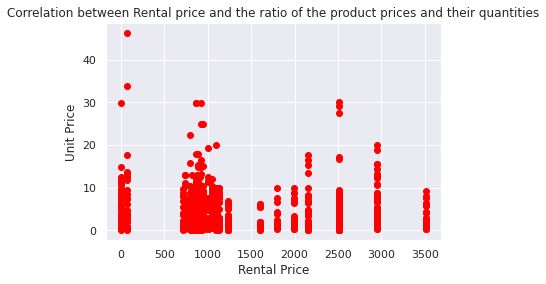

-0.019194570339233493

In [178]:
plt.scatter(productdata['Rental'][productdata["ratio"] < 100], productdata['ratio'][productdata["ratio"] < 100], color = 'red')
plt.title('Correlation between Rental price and the ratio of the product prices and their quantities')
plt.xlabel('Rental Price')
plt.ylabel('Unit Price')
plt.show()

productdata['Rental'][productdata["ratio"] < 100].corr(productdata['ratio'][productdata["ratio"] < 100])

In [153]:
productdata[productdata["ratio"] > 100]

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price,ratio,location_code,brand_code
1180,"Sainsbury's, 31-41 Liverpool Rd, The Angel, Lo...",Mid-range,UK,2515.50,Potatoes,4,0.10,38.3,383.000000,2,2
1457,"롯데마트(lotte mart), 서울특별시 중구 회현동 한강대로 405",Mid-range,South Korea,64.75,Rice,6,64.75,87500.0,1351.351351,3,2


Apples


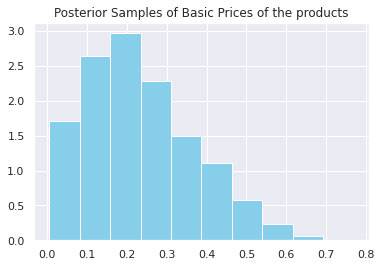

Bananas


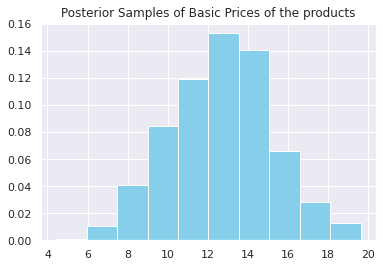

Tomatoes


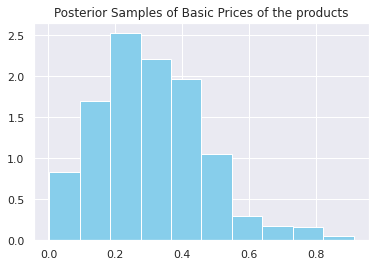

Potatoes


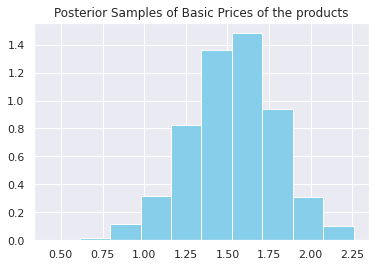

Flour


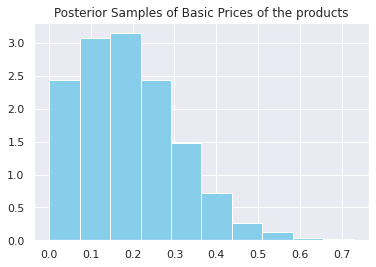

Rice


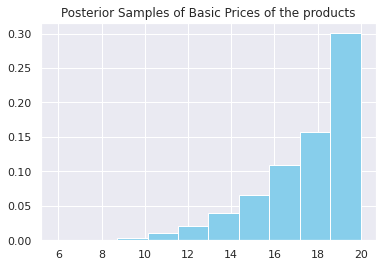

Milk


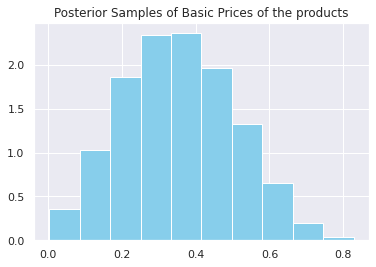

full cream


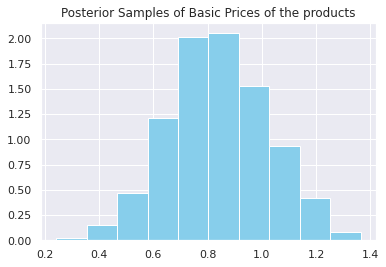

Butter


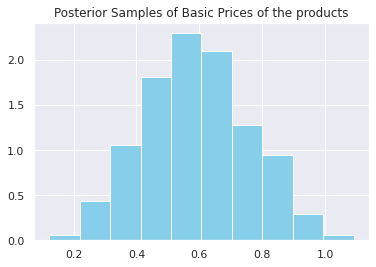

Eggs


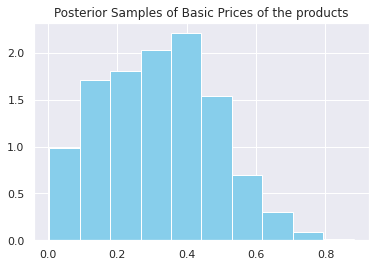

In [174]:
pdata = np.transpose(posterior_samples["basicprice"])
for i in range(10):
  plt.hist(pdata[i], density = True, color = 'skyblue')
  plt.title("Posterior Samples of Basic Prices of the products")
  print(product_list[i])

  plt.show()

In [182]:
productdata

,Store,Brand,Country,Rental,Product,Product ID,Quantity,Price,ratio,location_code,brand_code
0,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,826.00,826.00,1.000000,1,1
1,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,2.00,2.22,1.110000,1,1
2,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Apples,1,1.00,2.99,2.990000,1,1
3,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,1.49,1.490000,1,1
4,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),Germany,826.00,Bananas,2,1.00,3.90,3.900000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1545,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,3.99,0.332500,4,2
1546,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,12.00,6.19,0.515833,4,2
1547,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Rice,6,1.13,8.59,7.601770,4,2
1548,"Target; 115 4th St, San Francisco, CA 94103",Mid-range,United States,2953.65,Milk,7,0.45,6.49,14.422222,4,2
